In [1]:
#!pip install --user pyarrow

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.stats import spearmanr, mannwhitneyu, fisher_exact
from scipy.special import expit as sigmoid

In [2]:
conservation = pd.read_csv("../data/vep/conservation/Chr5.tsv.gz", sep="\t")
conservation

,pos,PhastCons,PhyloP
0,73,0.137841,0.486723
1,74,0.120058,0.630370
2,75,0.082986,-0.672660
3,76,0.083501,0.630370
4,77,0.070315,0.410230
...,...,...,...
24279498,26975493,0.149043,0.383414
24279499,26975494,0.139126,0.383414
24279500,26975495,0.121064,-0.819180
24279501,26975496,0.144156,0.383414


In [3]:
def compute_odds_ratio(df, threshold_quantile):
    df = df.copy()
    df.loc[df.model_score <= df.model_score.quantile(threshold_quantile), "ModelScoreTier"] = "Low"
    df.loc[df.model_score > df.model_score.quantile(threshold_quantile), "ModelScoreTier"] = "High"
    group_counts = df.groupby(["Status", "ModelScoreTier"]).size()
    try:
        group_counts = group_counts.values.reshape((2, 2))
    except:
        print("WARNING: count 0 in one bucket")
        return 1.0, 1.0
    odds_ratio, p_value = fisher_exact(group_counts, alternative='greater')
    return odds_ratio, p_value


def compute_vep_scores(model_name):
    print(model_name)
    if model_name in ["PhastCons", "PhyloP"]:
        df = pd.read_parquet("../data/vep/variants/filt.parquet")
    else:
        vep_mode, model_name2 = model_name.split("/")
        df = pd.read_parquet(f"../plantbert/{vep_mode}/vep_full_{model_name2}.parquet")
    df = df[df.AN >= 2000]
    df = df[(df.AC != 0) & (df.AC != df.AN)]
    df["AF"] = df.AC / df.AN
    df = df[df.AF < 0.5]
    df = df.merge(conservation, how="inner", on="pos")
    df.consequence = df.consequence.apply(lambda x: ','.join(sorted(list(set(x.split(","))))))
    
    df["Status"] = "Neither"
    df.loc[df.AC <= 10, "Status"] = "Rare"
    df.loc[df.AC > 100, "Status"] = "Common"
    df = df[df.Status!="Neither"]
    
    if model_name == "PhastCons":
        df["model_score"] = -df.PhastCons
    elif model_name == "PhyloP":
        df[".model_score"] = -(df.PhyloP.abs())
    elif vep_mode == "chromatin":
        pred_ref_cols = df.columns[df.columns.str.startswith("model_pred_ref_")]
        pred_alt_cols = df.columns[df.columns.str.startswith("model_pred_alt_")]
        pred_cols = np.concatenate([pred_ref_cols, pred_alt_cols])
        df[pred_cols] = sigmoid(df[pred_cols])
        feature_names = ["_".join(col.split("_")[3:]) for col in pred_ref_cols]
        delta_pred_cols = [f"delta_pred_{f}" for f in feature_names]
        df.loc[:, delta_pred_cols] = df[pred_alt_cols].values - df[pred_ref_cols].values
        df.loc[:, "model_score"] = -np.linalg.norm(df[delta_pred_cols].abs().values, ord=2, axis=1)
    elif vep_mode == "mlm":
        df["model_score"] = df.model_llr
        
    threshold_quantiles = np.logspace(-3, -1, 3)
    
    categories = [
        "all",
        "intron_variant,splice_region_variant",
        "5_prime_UTR_variant",
        "3_prime_UTR_variant",
        "intergenic_variant",
        "synonymous_variant",
        "missense_variant",
        "upstream_gene_variant",
        "intron_variant",
        "downstream_gene_variant",
    ]
    
    all_results = []
    for category in categories:
        df_category = df if category == "all" else df[df.consequence==category]
        
        odds_ratios, p_values = zip(*[compute_odds_ratio(df_category, threshold_quantile) for threshold_quantile in threshold_quantiles])
        results = pd.DataFrame(dict(threshold_quantile=threshold_quantiles, odds_ratio=odds_ratios, p_value=p_values))
        results["Test"] = "Odds-ratio"
        
        results = results.append({
            "Test": "Mann-Whitney",
            "p_value": mannwhitneyu(df_category.loc[df.Status=="Rare", "model_score"], df_category.loc[df.Status=="Common", "model_score"], alternative="less").pvalue
        }, ignore_index=True)
        
        results["Category"] = category
        all_results.append(results)
    all_results = pd.concat(all_results, ignore_index=True)
    all_results["Model"] = model_name
    all_results["Significant"] = all_results.p_value < 0.05
    
    return all_results

In [4]:
model_names = [
    "mlm/window-512_tokenization-no_model-convnet",
    "chromatin/DeepSEA",
    "PhastCons",
    "mlm/DNABERT",
]

results = pd.concat(
    [compute_vep_scores(model_name) for model_name in model_names],
    ignore_index=True
)

mlm/window-512_tokenization-no_model-convnet
chromatin/DeepSEA
PhastCons
mlm/DNABERT


In [5]:
results

,threshold_quantile,odds_ratio,p_value,Test,Category,Model,Significant
0,0.001,2.974650,8.619150e-24,Odds-ratio,all,mlm/window-512_tokenization-no_model-convnet,True
1,0.010,2.505247,1.322449e-171,Odds-ratio,all,mlm/window-512_tokenization-no_model-convnet,True
2,0.100,1.424309,2.552442e-310,Odds-ratio,all,mlm/window-512_tokenization-no_model-convnet,True
3,NaN,NaN,0.000000e+00,Mann-Whitney,all,mlm/window-512_tokenization-no_model-convnet,True
4,0.001,4.008677,1.213754e-01,Odds-ratio,"intron_variant,splice_region_variant",mlm/window-512_tokenization-no_model-convnet,False
...,...,...,...,...,...,...,...
155,NaN,NaN,9.409278e-13,Mann-Whitney,intron_variant,mlm/DNABERT,True
156,0.001,2.069691,1.573866e-01,Odds-ratio,downstream_gene_variant,mlm/DNABERT,False
157,0.010,1.649884,1.751873e-03,Odds-ratio,downstream_gene_variant,mlm/DNABERT,True
158,0.100,1.140270,4.819431e-03,Odds-ratio,downstream_gene_variant,mlm/DNABERT,True


In [6]:
results.to_csv(f"vep_metrics.tsv", sep="\t", index=False)

In [7]:
results.Model.replace({"mlm/window-512_tokenization-no_model-convnet": "mlm/ConvNet"}, inplace=True)

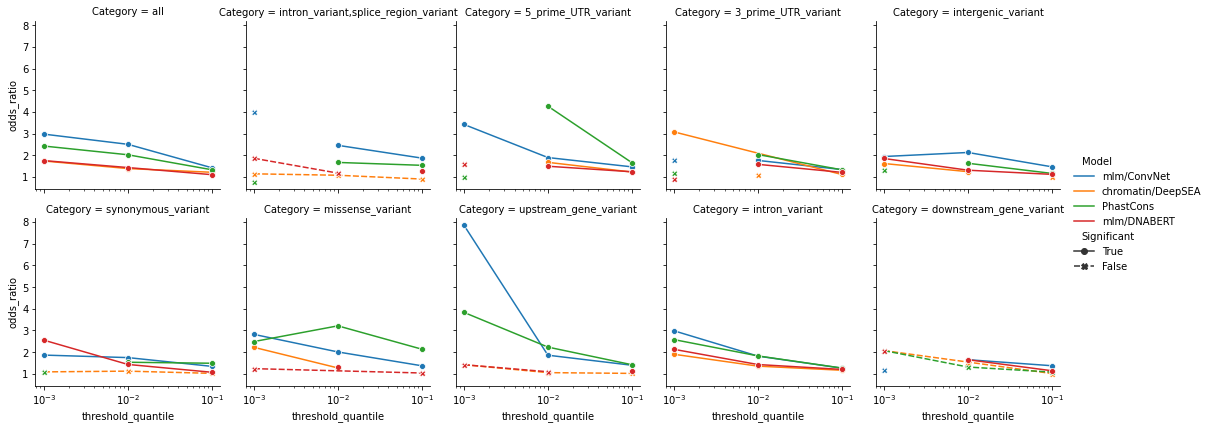

In [8]:
g = sns.relplot(
    data=results[results.Test=="Odds-ratio"],
    x="threshold_quantile",
    y="odds_ratio",
    hue="Model",
    style="Significant",
    style_order=[True, False],
    col="Category",
    height=3,
    #aspect=.7,
    kind="line",
    markers=True,
    col_wrap=5,
)

g.set(xscale='log');
plt.savefig("odds_ratios.pdf", bbox_inches='tight')

In [9]:
results_mw = results[results.Test=="Mann-Whitney"]
results_mw

,threshold_quantile,odds_ratio,p_value,Test,Category,Model,Significant
3,NaN,NaN,0.000000e+00,Mann-Whitney,all,mlm/ConvNet,True
7,NaN,NaN,4.529461e-37,Mann-Whitney,"intron_variant,splice_region_variant",mlm/ConvNet,True
11,NaN,NaN,1.191231e-39,Mann-Whitney,5_prime_UTR_variant,mlm/ConvNet,True
15,NaN,NaN,7.353018e-23,Mann-Whitney,3_prime_UTR_variant,mlm/ConvNet,True
19,NaN,NaN,2.342906e-85,Mann-Whitney,intergenic_variant,mlm/ConvNet,True
23,NaN,NaN,5.973294e-81,Mann-Whitney,synonymous_variant,mlm/ConvNet,True
27,NaN,NaN,4.735437e-88,Mann-Whitney,missense_variant,mlm/ConvNet,True
31,NaN,NaN,1.862836e-19,Mann-Whitney,upstream_gene_variant,mlm/ConvNet,True
35,NaN,NaN,2.993354e-56,Mann-Whitney,intron_variant,mlm/ConvNet,True
39,NaN,NaN,8.025570e-10,Mann-Whitney,downstream_gene_variant,mlm/ConvNet,True


In [10]:
results_mw["-log10_pvalue"] = results_mw.p_value.apply(lambda p_value: 300 if p_value==0.0 else -np.log10(p_value))

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


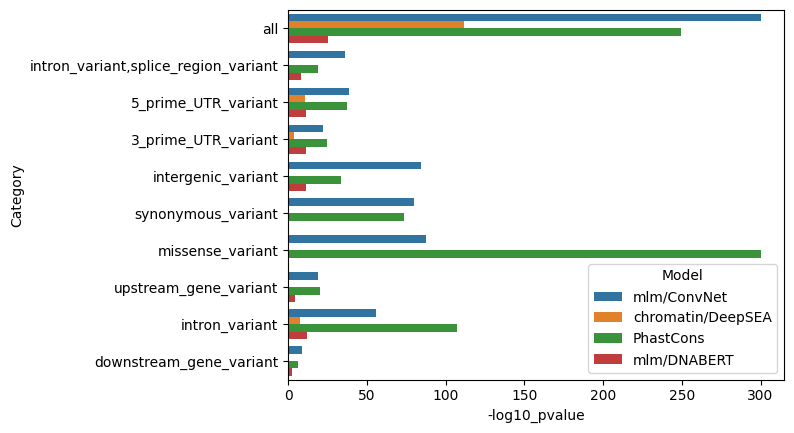

In [11]:
sns.barplot(
    y="Category",
    x="-log10_pvalue",
    hue="Model",
    data=results_mw,
)
plt.savefig("mann_whitney.pdf", bbox_inches='tight')